In [2]:
import numpy as np
import os
import json
import gzip
import struct
import random
import time
import signal

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'gray'

from IPython.display import clear_output, display

from netlib import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
with gzip.open("data/charts/BTC-USD.json.gz", "rb") as f:
     data = json.loads(f.read().decode("utf-8"))
ohlcv = np.array([entry[1:5] for entry in data])
print(ohlcv)

[[ 231.145   231.145   230.18    230.18  ]
 [ 232.4786  232.4787  232.4786  232.4787]
 [ 232.4784  232.4785  232.4784  232.4785]
 ...
 [6962.7    6968.     6952.8    6968.    ]
 [6950.     6950.     6950.     6950.    ]
 [6966.8    6974.     6966.8    6974.    ]]


In [4]:
avgs = 0.5*(ohlcv[:,0] + ohlcv[:,3])

decay = 0.999
expdev = []
accum = 0.0
for x in avgs:
    accum = decay*accum + (1.0 - decay)*x
    expdev.append(accum)
expdev = np.array(expdev)

data = avgs - expdev
dmean, dsvar = data.mean(), np.sqrt(data.var())
print(dmean, dsvar)
data = (data - dmean)/dsvar
print("%s values in data" % data.shape[0])
print(data)

7.4788753229113905 232.50882920938798
962796 values in data
[ 0.95890106  0.96571328  0.96471454 ... -1.07722349 -1.14213141
 -1.05337058]


In [5]:
val_size = 10000
tdata, vdata = data[:-val_size], data[-val_size:]
print("%s values in train data" % tdata.shape[0])

952796 values in train data


In [6]:
batch_size = 100

blen = len(tdata)//batch_size
print("%s values in sequence" % blen)
bseqdata = tdata[:blen*batch_size].reshape(batch_size, blen).transpose()
bseqdata = bseqdata.reshape(-1, batch_size, 1)

9527 values in sequence


In [7]:
signal_done = False

def signal_handler(signal, frame):
    global signal_done
    signal_done = True

def stop_on_signal():
    global signal_done
    signal_done = False
    signal.signal(signal.SIGINT, signal_handler)

In [8]:
def run_solvers(solvers, seqlen, pos=0, plot=True):
    stop_on_signal()
    while not signal_done:
        randseqlen = int(np.random.exponential(seqlen))
        for i, sol in enumerate(solvers):
            sol.learn(bseqdata[pos:pos+randseqlen], bseqdata[pos+1:pos+randseqlen+1], gprel=0.8)
        if plot:
            clear_output(wait=True)
            plot_solvers(plt, solvers)
        
        pos += randseqlen
        if pos >= bseqdata.shape[0] - 1:
            pos = 0
    return pos

In [ ]:
seqlen = 1440
hidden_size = 40

solvers = [
    RNNSolver(
        LSTM([2, hidden_size, 1]),
        optim, name=("LSTM %s" % (type(optim).__name__))
    ) for i, optim in enumerate([Adam(1e-2)])
]
pos = 0

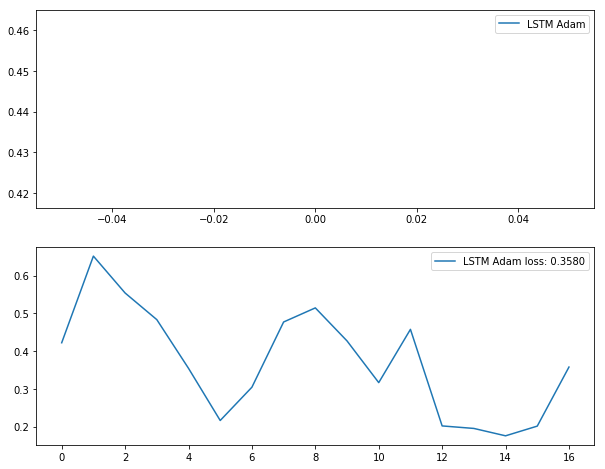

In [ ]:
pos = run_solvers(solvers, seqlen, pos)

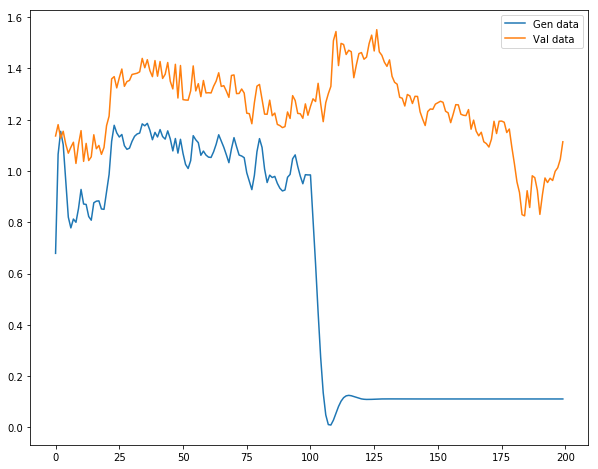

In [103]:
glen = 100
tgen, vgen = [], []

net = solvers[0].net
h, c = net.newstate(1)
for x in tdata[-glen:]:
    (y, h, c), _ = net.forward((np.array([x, 0.0]), h, c))
    tgen.append(y[0,0])
tgen = np.array(tgen)
    
for _ in range(len(vdata[:glen])):
    y = y[0,0]
    vgen.append(y)
    (y, h, c), _ = net.forward((np.array([y, 1.0]), h, c))
vgen = np.array(vgen)

plt.plot(np.concatenate((tgen, vgen)), label="Gen data")
plt.plot(np.concatenate((tdata[-glen:], vdata[:glen])), label="Val data")
plt.legend()

plt.show()